# Baseline 

#### Using the following paper: https://journals.sagepub.com/doi/epub/10.5772/56884

## Imports

In [1]:
import cv2
import time
import numpy as np
import pymeanshift as pms
import os
import pandas as pd
from matplotlib import pyplot as plt
from ipyfilechooser import FileChooser
from IPython.display import clear_output

## File Chooser

In [2]:
# Create and display a FileChooser widget
fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset')
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

## Main Algorithm

### Mean Shift Segmentation Approach

https://medium.com/@muhammetbolat/image-segmentation-using-k-means-clustering-algorithm-and-mean-shift-clustering-algorithm-fb6ebe4cb761

In [3]:
def mean_shift(img, processing_shape=(256,256), spatial_radius=6, range_radius=4.5, min_density=50): 
    
    original_shape = img.shape
    img = cv2.resize(img, processing_shape)
    (segmented_image, labels_image, number_regions) = pms.segment(img, spatial_radius=spatial_radius, range_radius=range_radius, min_density=min_density)

    #take the upper half of labels_image and take the most dominant label in the upper half
    upper_labels = labels_image[0:labels_image.shape[0]//2, 0:labels_image.shape[1]]
    unique, counts = np.unique(upper_labels, return_counts=True)
    dominant_label = unique[np.argmax(counts)]

    #create a mask from labels_image where dominant_label is sky and resize it to original shape
    mask = np.zeros(labels_image.shape, dtype=np.uint8)
    mask[labels_image == dominant_label] = 1
    mask = cv2.resize(mask, (original_shape[1],original_shape[0]))

    return mask, segmented_image, labels_image
    

#### Display Results

In [4]:
def display_results(filename, display_mode='display', data_mode = 'display', spatial_radius= 4, range_radius= 4.5, min_density= 50): 
    
    start_time = time.time()
    img = plt.imread(filename)
    mask, segmented_image, labels_image = mean_shift(img, spatial_radius=spatial_radius, range_radius=range_radius, min_density=min_density)
    time_taken = time.time() - start_time

    after_img = cv2.bitwise_and(img, img, mask=mask)

    #display the images in 2 subplots 
    if display_mode == 'display':
        print('------------------------------------------------------------------------------------------------------------------------')
        print("Processing: " + filename.split("\\")[-2] + ", spatial_radius: " + str(spatial_radius) + ", range_radius: " + str(range_radius) + ", min_density: " + str(min_density))
        print('Time taken: ', time_taken)
        
        plt.title('Segmented Image')
        plt.imshow(segmented_image)
        plt.show()

        plt.title('Labels Image')
        plt.imshow(labels_image)
        plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
        fig.suptitle('Sky Segmentation')
        ax1.imshow(after_img)
        ax1.set_title('Result')
        ax2.imshow(plt.imread(filename))
        ax2.set_title('Original Image')
        plt.show()

        if data_mode == 'validate':
            val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\ValidationImages\\Skyfinder\\" + filename.split("\\")[-2] + ".png")
            val_image = cv2.cvtColor(val_image, cv2.COLOR_BGR2GRAY)

            #calculate the precision and recall
            true_pos = np.sum(np.logical_and(val_image, mask))
            false_pos = np.sum(np.logical_and(np.logical_not(val_image), mask))
            false_neg = np.sum(np.logical_and(val_image, np.logical_not(mask)))
            precision = true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1 = 2 * (precision * recall) / (precision + recall)

            print("Precision: " + str(precision))
            print("Recall: " + str(recall))
            print("F1: " + str(f1))

            print('------------------------------------------------------------------------------------------------------------------------')
            return [precision, recall, f1, filename, time_taken, spatial_radius, range_radius, min_density]
        
        elif data_mode == 'display':
            print('------------------------------------------------------------------------------------------------------------------------')
            return [0, 0, 0, filename, time_taken, spatial_radius, range_radius, min_density]
        
    else:
        if data_mode == 'validate':
            val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\ValidationImages\\Skyfinder\\" + filename.split("\\")[-2] + ".png")
            val_image = cv2.cvtColor(val_image, cv2.COLOR_BGR2GRAY)

            #calculate the precision and recall
            true_pos = np.sum(np.logical_and(val_image, mask))
            false_pos = np.sum(np.logical_and(np.logical_not(val_image), mask))
            false_neg = np.sum(np.logical_and(val_image, np.logical_not(mask)))
            precision = true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1 = 2 * (precision * recall) / (precision + recall)

            return [precision, recall, f1, filename, time_taken, spatial_radius, range_radius, min_density]
        
        elif data_mode == 'display':
            return [0, 0, 0, filename, time_taken, spatial_radius, range_radius, min_density]
        


#### Individual Image Testing

------------------------------------------------------------------------------------------------------------------------
Processing: 65, spatial_radius: 8, range_radius: 6, min_density: 50
Time taken:  0.6812143325805664


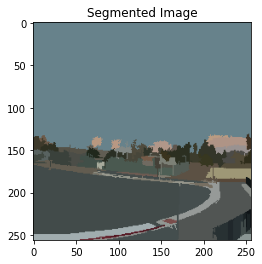

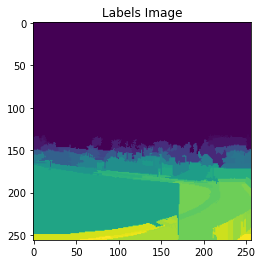

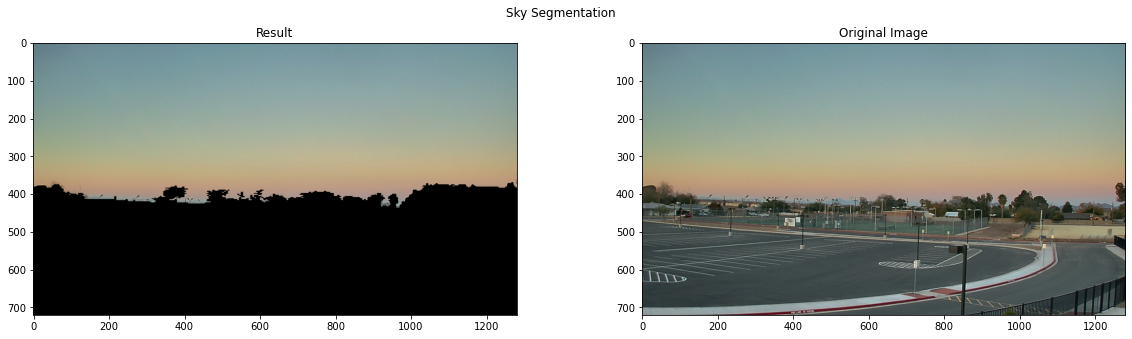

Precision: 0.9809293701405627
Recall: 0.9755600299098033
F1: 0.9782373322841379
------------------------------------------------------------------------------------------------------------------------


In [5]:
#for q in np.arange(0.02, 0.22, 0.02):
for k in np.arange(6, 7, 1):   
    _ = display_results(fc.selected, display_mode = 'display',data_mode='validate', spatial_radius=8, range_radius=k, min_density=50)

### Data for random 1000 images

In [6]:
sr_array = [i for i in range(2, 16, 2)]
rr_array = [i for i in range(2, 16, 2)]
min_array = [i for i in range(150, 550, 100)]

results = pd.DataFrame(columns=['precision', 'recall', 'f1', 'filename', 'time_taken', 'spatial_radius', 'range_radius', 'min_density'])

#iterate through 1000 random images
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\OriginalImages") for f in filenames if os.path.splitext(f)[1] == '.jpg']
random = [np.random.randint(0, len(files)) for i in range(0, 1)]
for i in random:
    for j in sr_array:
        for k in rr_array:
            for l in min_array:
                clear_output(wait=True)
                print("File: " + str(files[i]) + "\nspatial_radius=" + str(j) + ": \n     range_radius=" + str(k) + ": \n          min_density=" + str(l) + ": ")
                results.loc[len(results)] = display_results(files[i], display_mode = 'not_display' ,data_mode='validate', spatial_radius=j, range_radius=k, min_density=l)

#remove all nan values from results
results = results.dropna()

#save the results to a csv file
results.to_csv('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\results.csv')

File: C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\260\20130430_161452.jpg
spatial_radius=14: 
     range_radius=14: 
          min_density=450: 


In [ ]:
#print the results in a loop for each spatial_range, range_radius, and min_density
for i in sr_array:
    for j in rr_array:
        for k in min_array:
            print('------------------------------------------------------------------------------------------------------------------------')
            print("For spatial_radius=" + str(i) + ", range_radius=" + str(j) + ", min_density=" + str(k) + ": ")
            print('------------------------------------------------------------------------------------------------------------------------')
            print("Average Precision: " + str(np.mean([l[0] for l in [m for m in [n for n in results.values if n[5] == i] if m[6] == j] if l[7] == k])))
            print("Average Recall: " + str(np.mean([l[1] for l in [m for m in [n for n in results.values if n[5] == i] if m[6] == j] if l[7] == k])))
            print("Average F1: " + str(np.mean([l[2] for l in [m for m in [n for n in results.values if n[5] == i] if m[6] == j] if l[7] == k])))
            print("Average Time: " + str(np.mean([l[4] for l in [m for m in [n for n in results.values if n[5] == i] if m[6] == j] if l[7] == k])))
            print('------------------------------------------------------------------------------------------------------------------------')

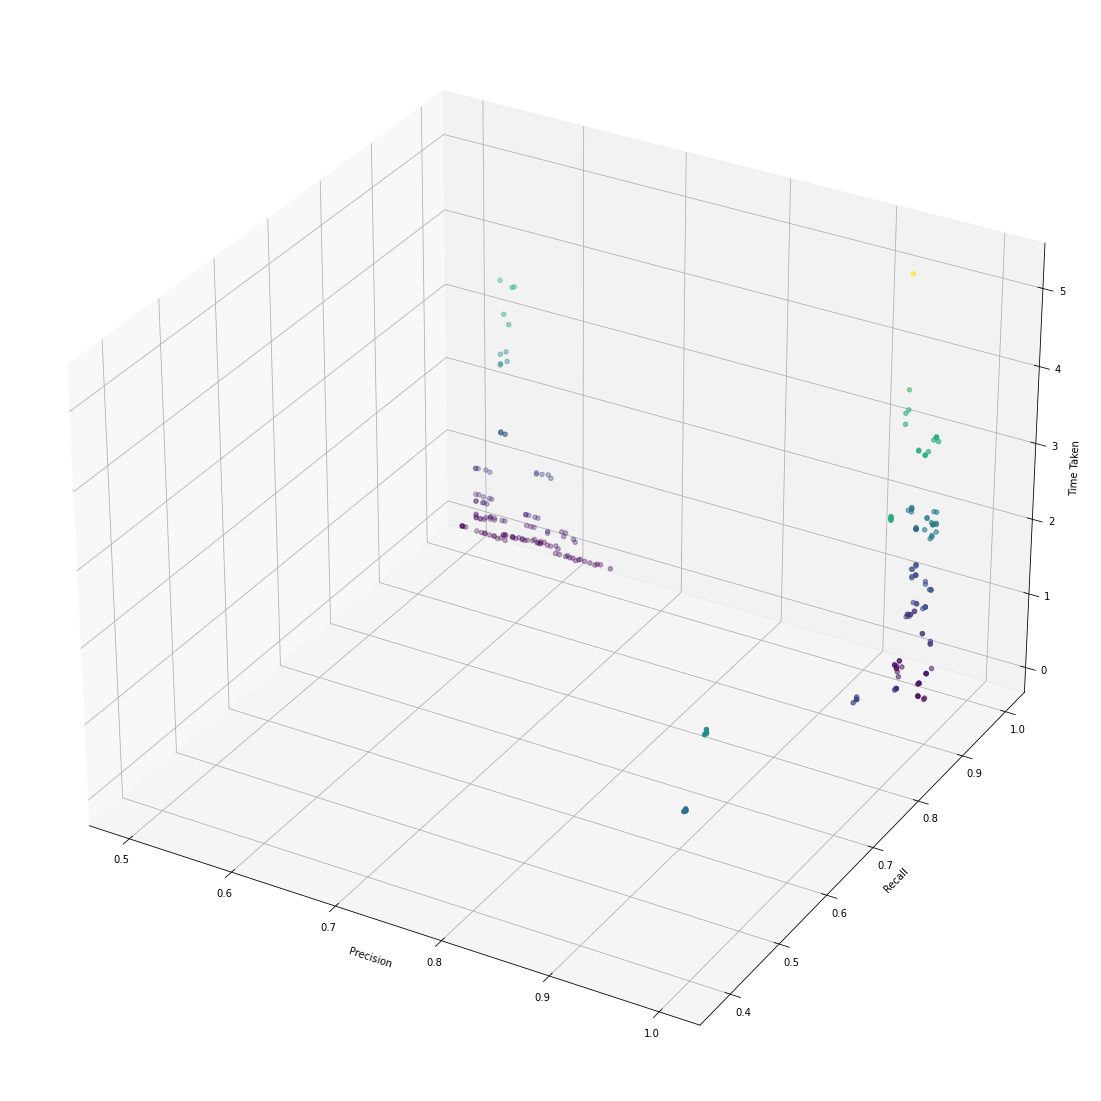

In [11]:
#make a 3d plot of the result for precision, recall and time taken
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results['precision'], results['recall'], results['time_taken'], c=results['time_taken'], cmap='viridis')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_zlabel('Time Taken')
plt.show()

### Mean Shift Segmentation for Video

In [38]:
cap = cv2.VideoCapture('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\video_4.mp4')
result = cv2.VideoWriter('saved_video_4.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, (int(cap.get(3)), int(cap.get(4))))

counter = 0

while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        if counter % 2 == 0:
            start_time = time.time()
            frame = cv2.rotate(frame, cv2.ROTATE_180)
            mask, segmented_image, labels_image = mean_shift(frame, spatial_radius=7, range_radius=7, min_density=200)
            after_img = cv2.bitwise_and(frame, frame, mask=mask)
            segmented_image = cv2.resize(segmented_image, (int(cap.get(3)), int(cap.get(4))))
            result.write(after_img)
            print("Time taken: ", time.time() - start_time, "s")
        counter += 1
    else:
        break

Time taken:  0.6514055728912354 s
Time taken:  0.6562507152557373 s
Time taken:  0.6336736679077148 s
Time taken:  0.6221697330474854 s
Time taken:  0.6465859413146973 s
Time taken:  0.6549358367919922 s
Time taken:  0.6382110118865967 s
Time taken:  0.6216704845428467 s
Time taken:  0.6381237506866455 s
Time taken:  0.645172119140625 s
Time taken:  0.6450247764587402 s
Time taken:  0.6286699771881104 s
Time taken:  0.6331276893615723 s
Time taken:  0.6510655879974365 s
Time taken:  0.6513335704803467 s
Time taken:  0.6392295360565186 s
Time taken:  0.6330990791320801 s
Time taken:  0.6451401710510254 s
Time taken:  0.6240947246551514 s
Time taken:  0.6426117420196533 s
Time taken:  0.6170978546142578 s
Time taken:  0.6371481418609619 s
Time taken:  0.6230912208557129 s
Time taken:  0.6251082420349121 s
Time taken:  0.6321203708648682 s
Time taken:  0.6311004161834717 s
Time taken:  0.6286320686340332 s
Time taken:  0.6391017436981201 s
Time taken:  0.6341376304626465 s
Time taken:  0.

#### Metrics: Precision, Recall, F1-Score

In [8]:
def plot_all_varaitions(results, sort_by, sr, rr, min):
    #sort (0 = Precision, 1 = Recall, 2 = F1)
    results.sort(key=lambda x: x[sort_by])

    #display the subplots for all metrics in one plot
    fig, axs = plt.subplots(3, 1, figsize=(30, 10))
    axs[0].plot([i[0] for i in results], label="Precision")
    axs[0].set_title('Precision, Spatial Radius = ' + str(sr) + ', Range Radius = ' + str(rr) +', Min Density = ' + str(min))
    axs[1].plot([i[1] for i in results], label="Recall", color='orange')
    axs[1].set_title('Recall, Spatial Radius = ' + str(sr) + ', Range Radius = ' + str(rr) +', Min Density = ' + str(min))
    axs[2].plot([i[2] for i in results], label="F1", color='green')
    axs[2].set_title('F1, Spatial Radius = ' + str(sr) + ', Range Radius = ' + str(rr) +', Min Density = ' + str(min))
    plt.show()

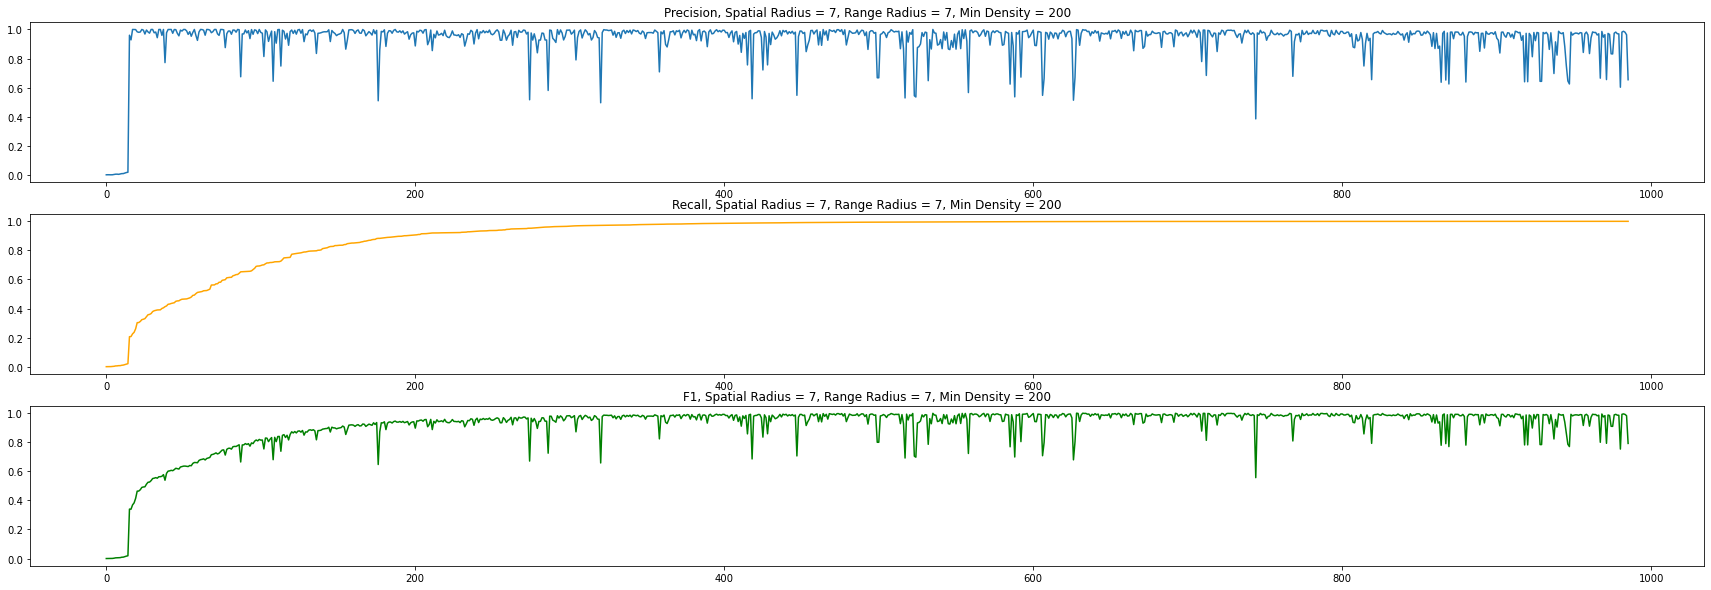

In [9]:
plot_all_varaitions(acc_7_7_200, 1, 7, 7, 200)

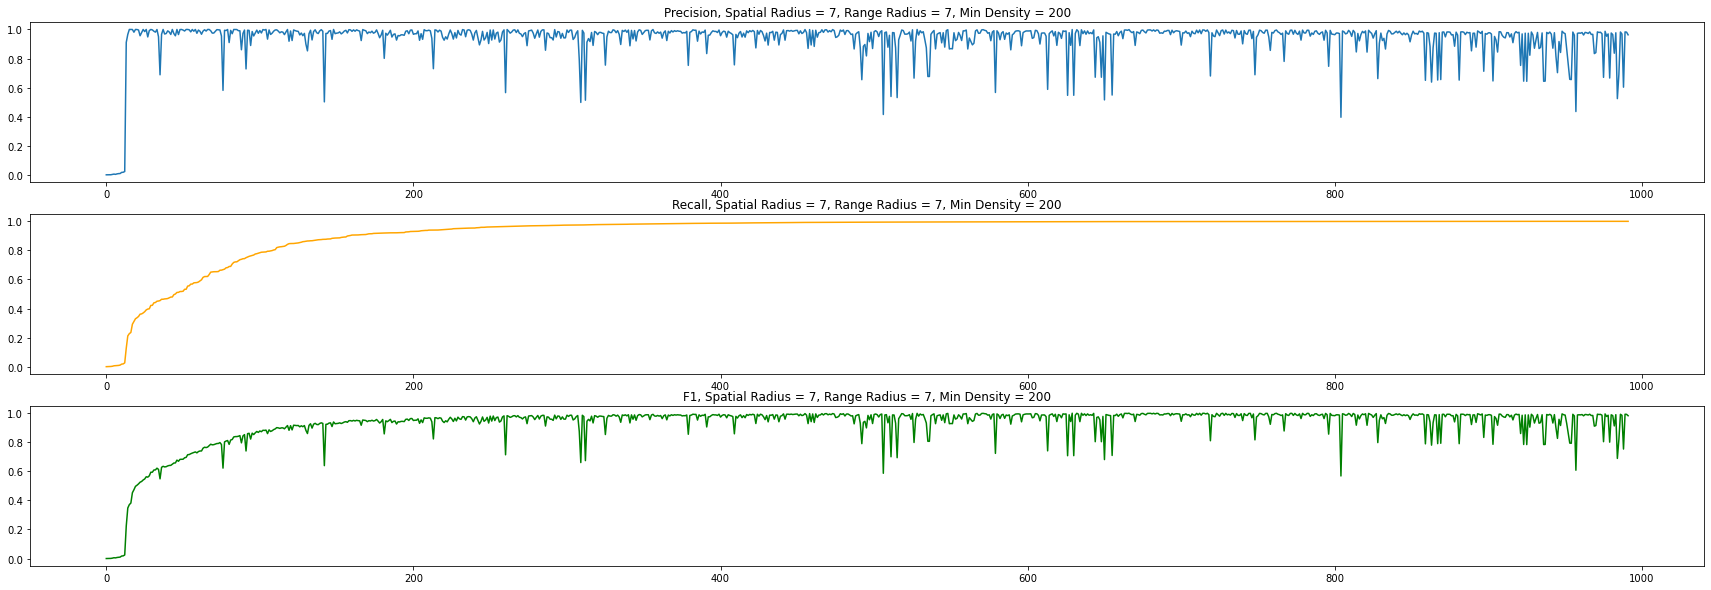

In [10]:
plot_all_varaitions(acc_5_6_100, 1, 5, 6, 100)

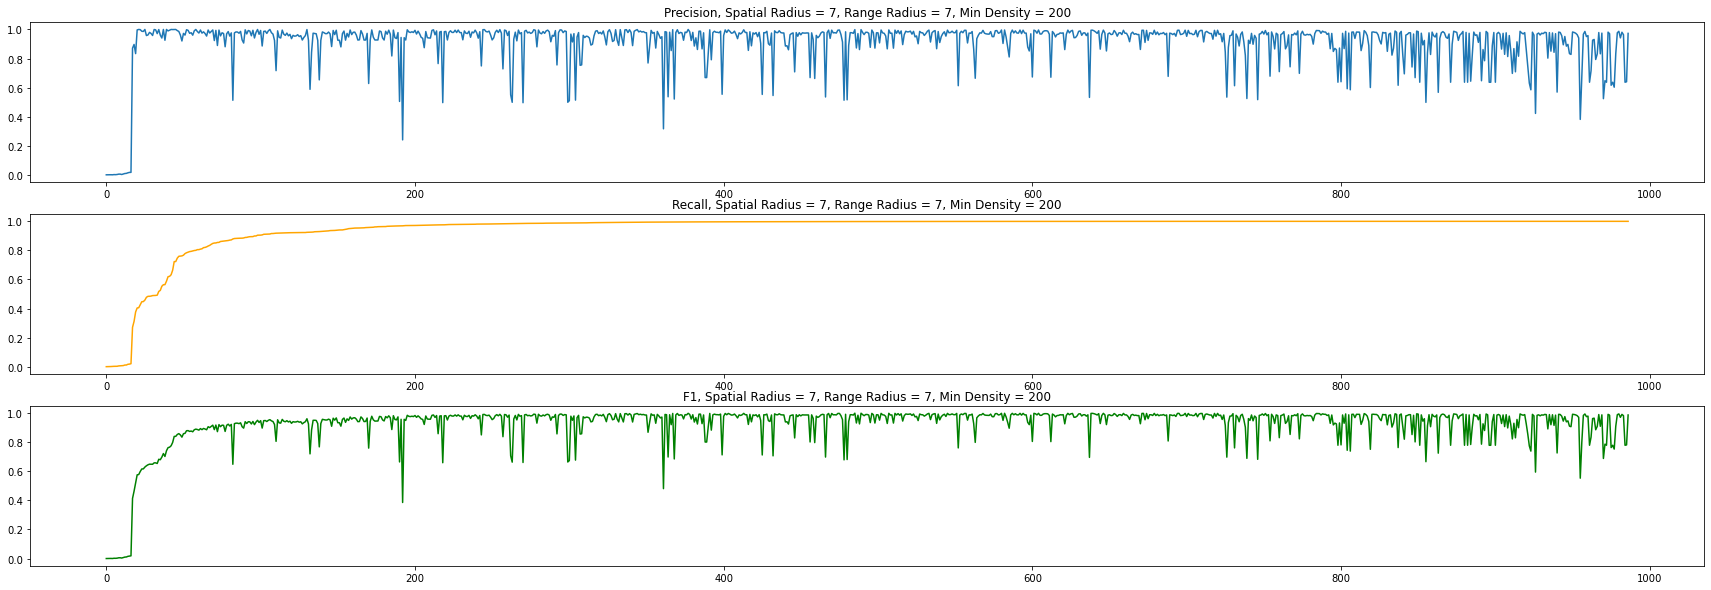

In [11]:
plot_all_varaitions(acc_5_8_300, 1, 5, 8, 300)

### Show worst 10 images

Worst 10 images based on precision: 
------------------------------------------------------------------------------------------------------------------------
Processing: 9291, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.7253754138946533


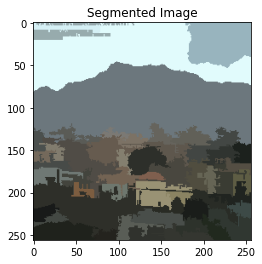

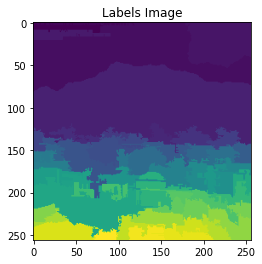

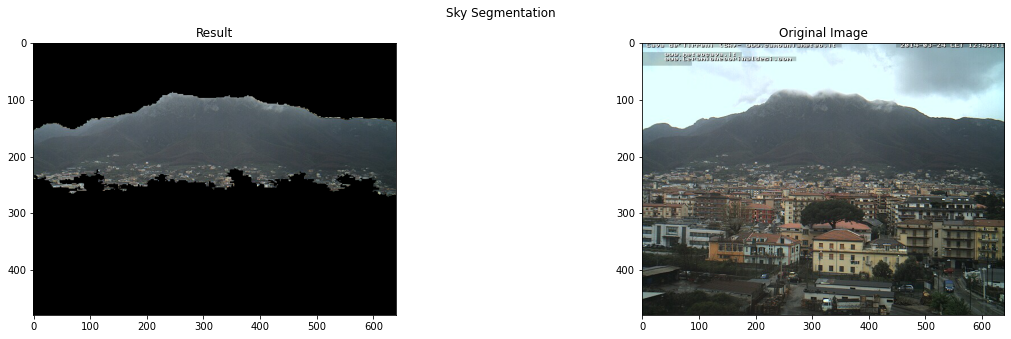

Precision: 0.00024740227610094015
Recall: 0.0003064711380805713
F1: 0.00027378695268276995
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 260, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.8529002666473389


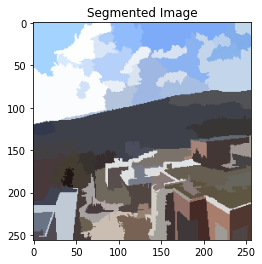

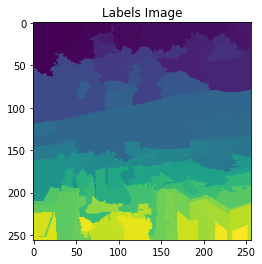

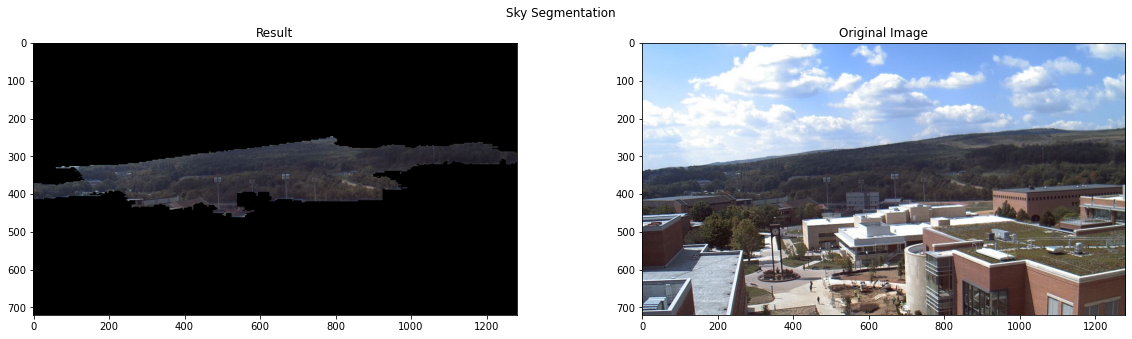

Precision: 0.0003417236853346174
Recall: 0.00012699842117871852
F1: 0.00018517739152392577
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 19306, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.8245275020599365


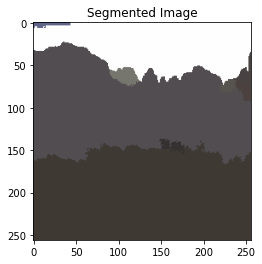

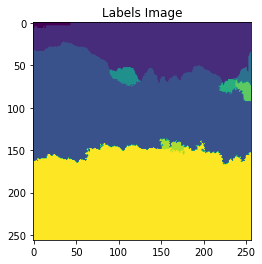

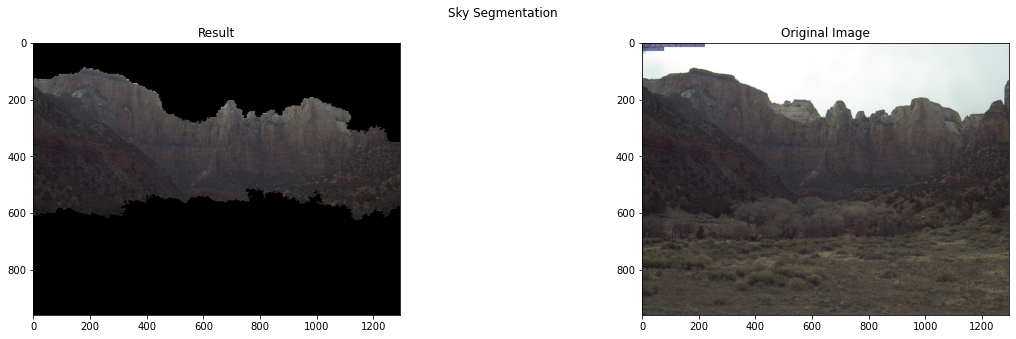

Precision: 0.0003461412726460791
Recall: 0.0006790630606461998
F1: 0.00045854615394413386
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 19306, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.8926181793212891


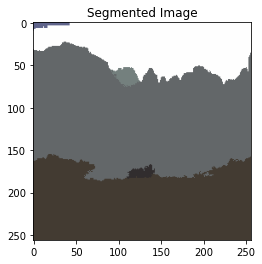

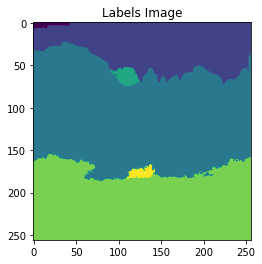

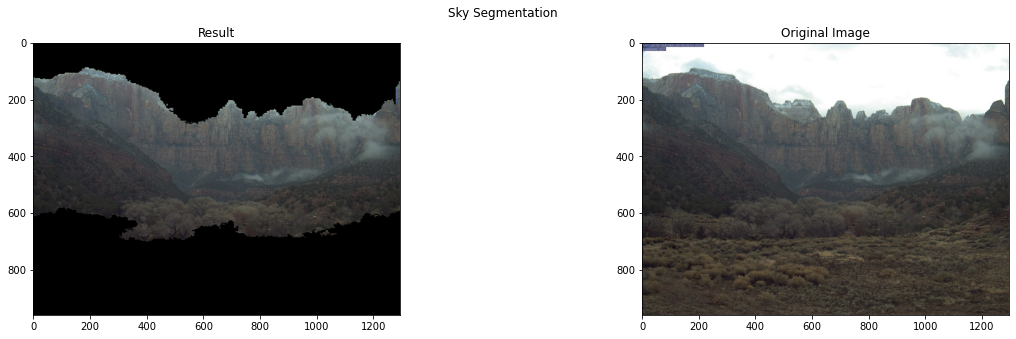

Precision: 0.0007040367060698267
Recall: 0.001718616388055197
F1: 0.000998879306144326
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 260, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.9218437671661377


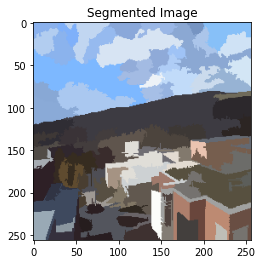

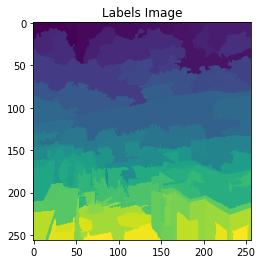

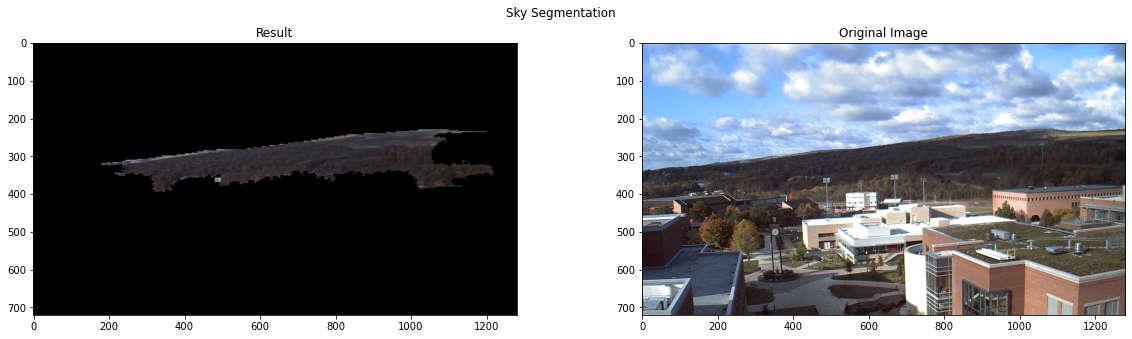

Precision: 0.0007714821028397889
Recall: 0.00018183864850589244
F1: 0.00029430863165172546
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 9291, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.8494315147399902


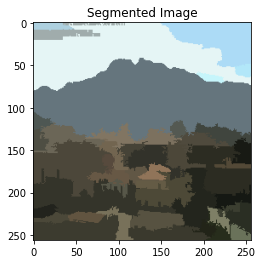

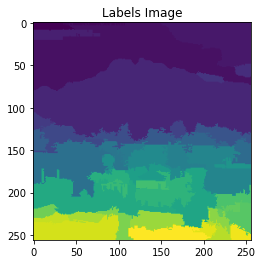

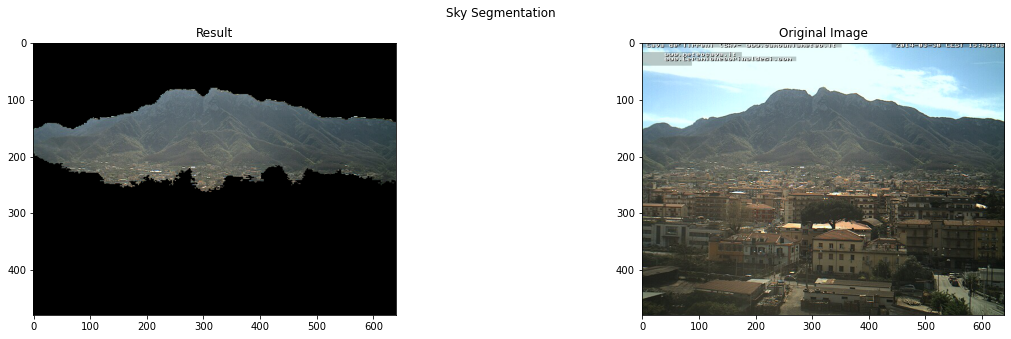

Precision: 0.002320763623013584
Recall: 0.0027122695720130556
F1: 0.0025012895065959144
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 9291, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.7171225547790527


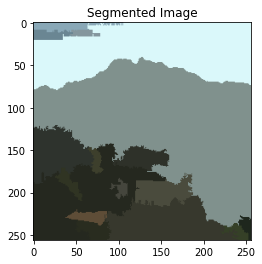

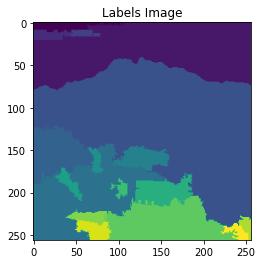

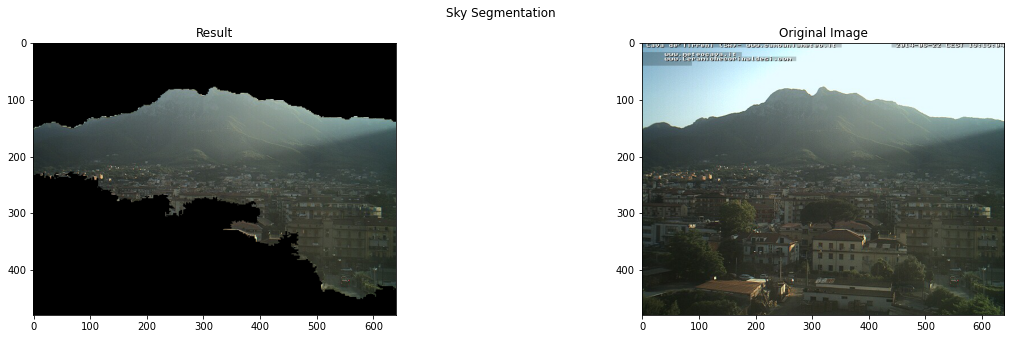

Precision: 0.0035550730510172097
Recall: 0.007125453960373282
F1: 0.004743494272103153
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 9291, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.7863407135009766


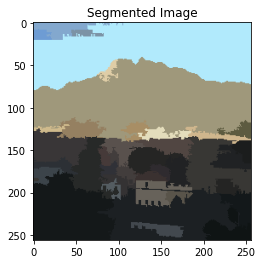

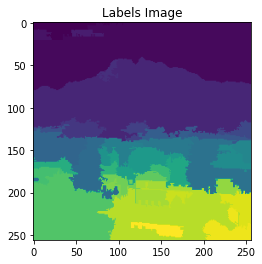

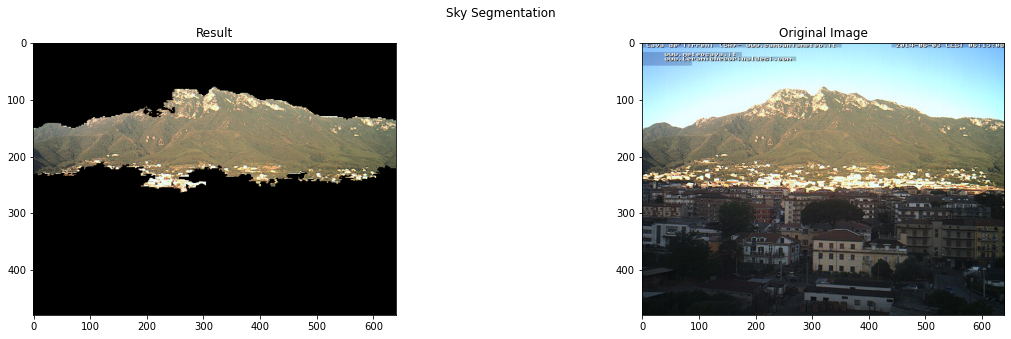

Precision: 0.004514702927188693
Recall: 0.005164038676657626
F1: 0.004817589204025618
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 9291, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.7206203937530518


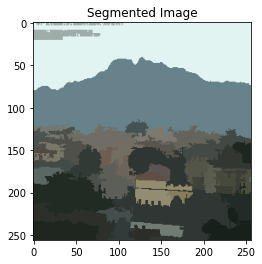

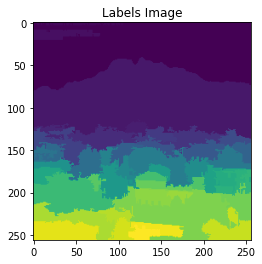

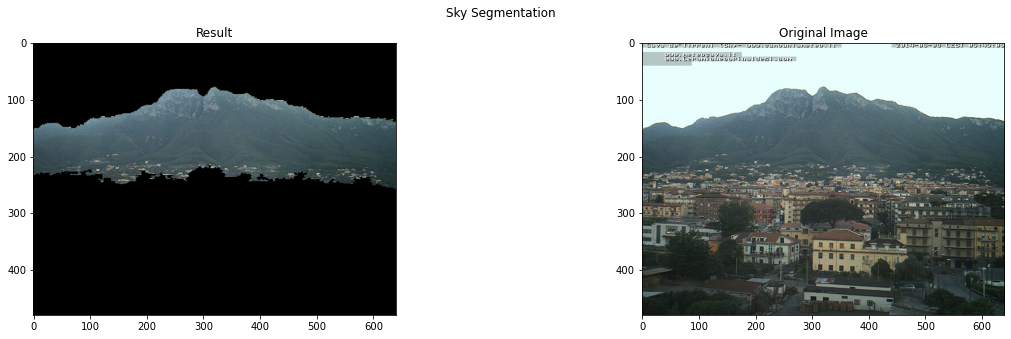

Precision: 0.0047310048861198
Recall: 0.005608421826874454
F1: 0.0051324839960454624
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Processing: 9291, spatial_radius: 7, range_radius: 7, min_density: 200
Time taken:  0.7807824611663818


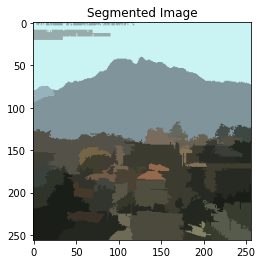

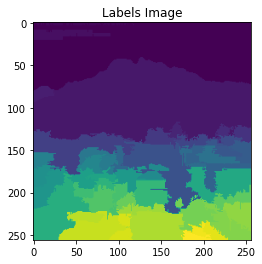

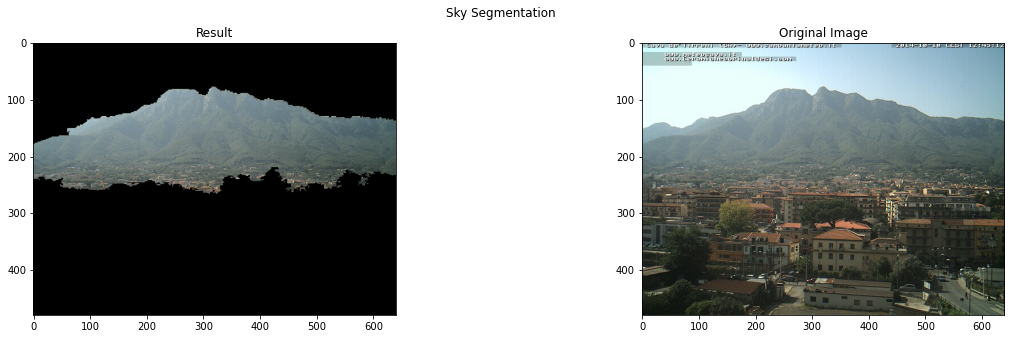

Precision: 0.0057269581322805475
Recall: 0.007202071744893425
F1: 0.0063803647668112425
------------------------------------------------------------------------------------------------------------------------


In [12]:
#print the worst 10 images based on precision using filenames on 4th column
acc_7_7_200.sort(key=lambda x: x[0])
print("Worst 10 images based on precision: ")
for i in range(0, 10):
    _ = display_results(acc_7_7_200[i][3], display_mode = 'display' ,data_mode='validate', spatial_radius=7, range_radius=7, min_density=200)

### Save Results

In [30]:
import csv

#save the results in a csv file for each
with open('acc_7_7_200.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Precision", "Recall", "F1", "Image", "Time"])
    writer.writerows(acc_7_7_200)

with open('acc_5_6_100.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Precision", "Recall", "F1", "Image", "Time"])
    writer.writerows(acc_5_6_100)

with open('acc_5_8_300.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Precision", "Recall", "F1", "Image", "Time"])
    writer.writerows(acc_5_8_300)

# Deep Learning Methodology

Desigining a model and input pipeline for the data

### Imports

In [4]:
#load the dataset
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
#import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
#from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import pandas as pd
#dataset = tf.data.Dataset.load("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\SkyDataset")

### Input Pipeline

Only run to create the dataset

In [5]:
#set tensorflow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

#create a function that imports image_paths.csv and converts it into a tf.data.Dataset
def get_dataset(image_paths, label_paths):

    def _parse_function(image_path, label_path):

        image_string = tf.io.read_file(image_path)
        label_string = tf.io.read_file(label_path)

        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        label_decoded = tf.image.decode_png(label_string, channels=1)

        image_decoded = tf.cast(image_decoded, tf.int32)
        label_decoded = tf.where(label_decoded > 0, 1, 0)
        return image_decoded, label_decoded

    epoch_size = len(image_paths)
    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    label_paths = tf.convert_to_tensor(label_paths, dtype=tf.string)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(_parse_function, num_parallel_calls=8)

    return dataset

#import image_paths.csv into a dataframe
df = pd.read_csv("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\image_paths.csv")
image_paths = df["image_path"].tolist()
label_paths = df["label"].tolist()

#load the dataset
dataset = get_dataset(image_paths, label_paths)

#shuffle dataset
dataset = dataset.shuffle(10000)

#split the dataset into train and test
test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)

#print the length of the dataset
print(len(dataset))

#save the dataset as a file
#tf.data.Dataset.save(dataset, "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\SkyDataset")

38115


(480, 640, 3)


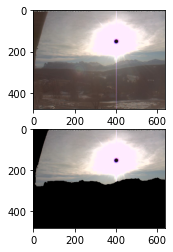

In [6]:
#print first 5 images in the dataset
for image, label in dataset.take(1):
    #mask the image with the label
    image_masked = image * label # type: ignore

    print(image_masked.shape)

    plt.figure(1)
    plt.subplot(2,1,1)
    plt.imshow(image)
    #plt.subplot(2,1,2)
    #plt.imshow(label)
    plt.subplot(2,1,2)
    plt.imshow(image_masked)
    plt.show()

In [36]:
#create a unet model that trains on the dataset
def unet(input_size=(480, 640, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate(axis = 3)([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis = 3)([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis = 3)([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis = 3)([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    #model.summary()

    return model

37115

### Trash

In [ ]:
def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w):
        raw = mask[:, i]
        after_median = medfilt(raw, 19) #perform median filter on the column
        try:
            first_zero_index = np.where(after_median == 0)[0][0] #get the index of the first zero value in the column
            first_one_index = np.where(after_median == 1)[0][0] #get the index of the first one value in the column
            if first_zero_index > 20:  #find the region between first zero and first one and paint it 1
                mask[first_one_index:first_zero_index, i] = 1
                mask[first_zero_index:, i] = 0
                mask[:first_one_index, i] = 0
        except:
            continue
        
    return mask


def get_sky_region_gradient(img, ksize=3, threshold=9):

    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grayscale
    img_gray = cv2.blur(img_gray, (9, 3)) #blur the image to reduce noise
    cv2.medianBlur(img_gray, 5) #blue with median filter

    #lap = cv2.Laplacian(img_gray, cv2.CV_8U) #get the laplacian of the image

    #get the sobel operator in x and y direction and take L2 norm of the two
    sobelx = cv2.Sobel(img_gray, cv2.CV_8U, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_gray, cv2.CV_8U, 0, 1, ksize=ksize)
    sobel = np.float32(np.sqrt(sobelx ** 2 + sobely ** 2))

    #print("Sobel Operator Output: ")
    #plt.figure(figsize=(20, 20))
    #plt.imshow(sobel)
    #plt.show()
    
    gradient_mask = (sobel < threshold).astype(np.uint8) #get the gradient mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)) #create a kernel for morphological operations

    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #perform Morphological Erosion
    mask = cal_skyline(mask) #calculate the skyline of the image
    #mask_inverted = 1 - mask #invert the mask

    after_img = cv2.bitwise_and(img, img, mask=mask) #perform bitwise and to apply the mask from cal_skylines

    """#get the average color of after_img
    avg_color_per_row = np.average(after_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    #calculate the standard deviation of after_img
    std_color_per_row = np.std(after_img, axis=0)
    std_color = np.std(std_color_per_row, axis=0)

    #calculate the probability distribution of the image standardised with avg_color and std_color
    prob_color = np.exp(-1*((img - avg_color) ** 2) / (5 * std_color ** 2))
    prob_color = np.sum(prob_color, axis=2)   #check for probability 
    prob_color = 1 - (prob_color / np.sum(prob_color)) #normalize the probability distribution
    #prob_color = (prob_color - np.min(prob_color)) / (np.max(prob_color) - np.min(prob_color)) #scale between 0 and 1

    #NOTE: Clearly not gaussian as 1 - prob_color != inverted(prob_color)

    #calculate the exponential probability distribution of gradient_mask
    prob_gradient = np.exp(-1*((1 - gradient_mask) ** 2))
    #prob_gradient = (prob_gradient - np.min(prob_gradient)) / (np.max(prob_gradient) - np.min(prob_gradient)) #scale between 0 and 1

    #calculate the exponential probability of vertical pixel value divided by total height for the width of the image
    prob_vertical = np.tile(np.exp(-1*((np.arange(h) / h) ** 2)), (w, 1)).T
    #prob_vertical = (prob_vertical - np.min(prob_vertical)) / (np.max(prob_vertical) - np.min(prob_vertical)) #scale between 0 and 1

    #show the prob_dist as image
    #print("Exponential Distribution of the color of the image based on the average color and standard deviation of the sky region: ")
    #print(prob_color)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_color)
    #plt.show()


    #show prob_gradient as image
    #print("Expontential Distribution of the gradient of the image:")
    #print(prob_gradient)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_gradient)
    #plt.show()

    #show prob_vertical as image
    #print("Exponential Distribution of the vertical pixel value:")
    #print(prob_vertical)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_vertical)
    #plt.show()

    #multiply the three probability distributions
    prob_dist = prob_color * prob_vertical * prob_gradient

    #show the final probability distribution as image
    #print("Final Probability Distribution:")
    #print(prob_dist)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_dist)
    #plt.show()

    #show image with mask applied
    #print("Image with mask applied:")
    #plt.figure(figsize=(20, 20))
    #plt.imshow(cv2.bitwise_and(img, img, mask=mask))
    #plt.show()

    #create a mask from the probability distribution by thresholding it with 1 * 10^-5
    prob_mask = (prob_dist > 6 * 10 ** -1).astype(np.uint8)

    after_img = cv2.bitwise_and(img, img, mask=prob_mask)"""

    prob_mask = mask

    return after_img, mask, prob_mask

In [ ]:
def multi_task(file):
    img = cv2.imread(file)[:,:,::-1]
    val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\ValidationImages\\Skyfinder\\" + file.split("\\")[-2] + ".png")
#print("Original Image:")
#plt.figure(figsize=(20, 20))
#plt.imshow(img)
#plt.show()

    _, mask_3_9, _ = get_sky_region_gradient(img, 3, 9)
    _, mask_5_9, _ = get_sky_region_gradient(img, 5, 9)
    _, mask_7_9, _ = get_sky_region_gradient(img, 7, 9)
#print("Image with sky region removed:")
#plt.figure(figsize=(20, 20))
#plt.imshow(img_sky)
#plt.show()\


#print("Ground Truth Image:")
#plt.figure(figsize=(20, 20))
#plt.imshow(val_image)
#plt.show()

#calculate the accuracy of the mask
#print("Accuracy of the mask: " + str(np.sum(mask == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])))
#print("Accuracy of the prob_mask: " + str(np.sum(prob_mask == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])))
    print("file: " + str(file.split("\\")[-2]))

#append the accuracy values in a 2D array
    return [np.sum(mask_3_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1]), np.sum(mask_5_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1]), np.sum(mask_7_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])]

    #print("iterations: " + str(len(acc)))

In [ ]:
acc = []
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\OriginalImages") for f in filenames if os.path.splitext(f)[1] == '.jpg']
for file in files:
    acc.append(multi_task(file))

file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file

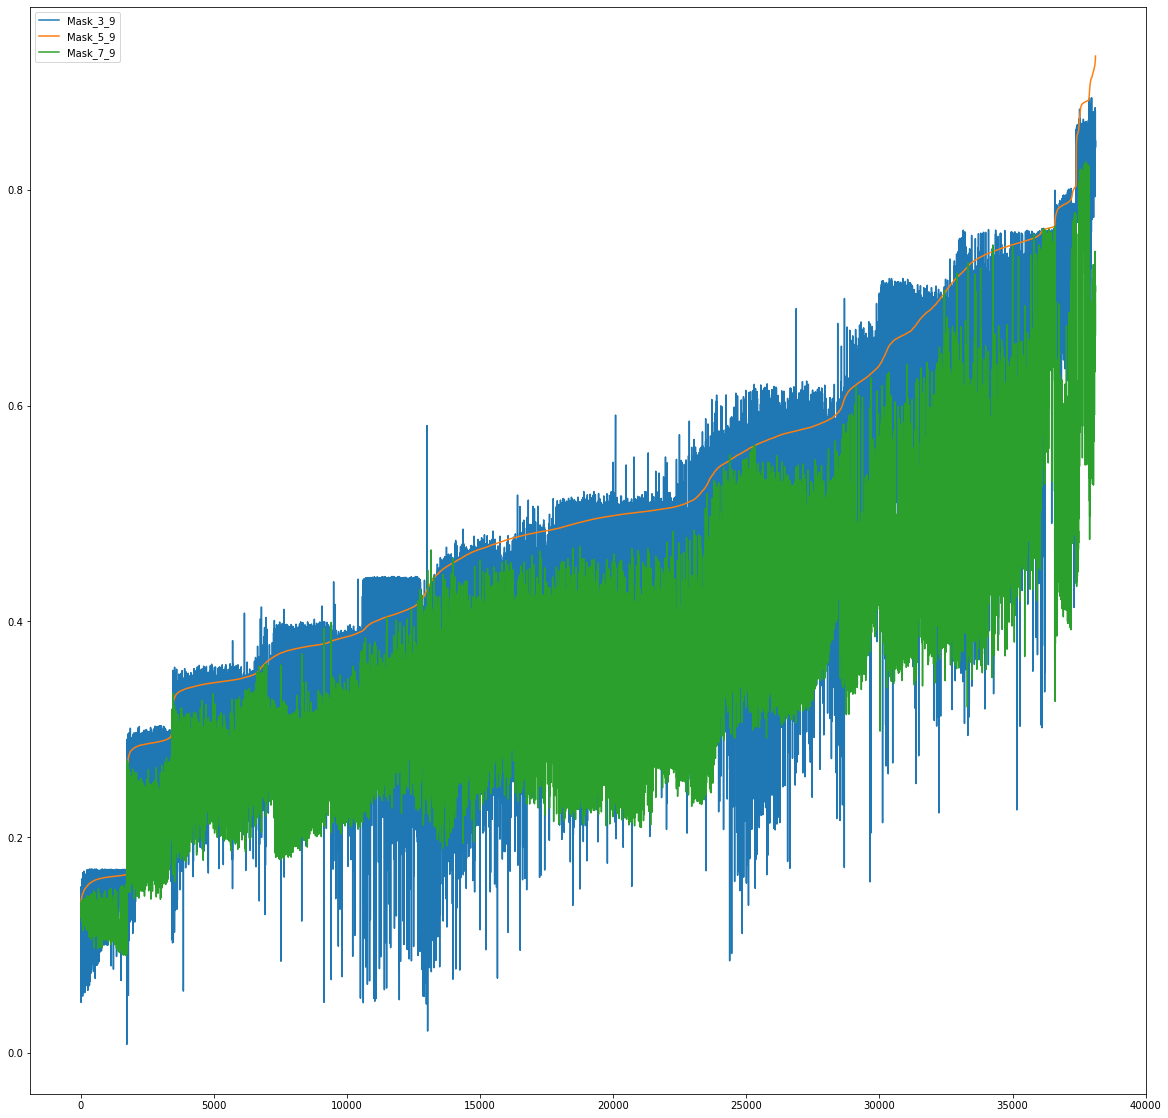

In [ ]:
#sort acc
acc.sort(key=lambda x: x[1])

#plot acc as a line graph with the x-axis being the number of iterations and the y-axis being the accuracy
plt.figure(figsize=(20, 20))
plt.plot(np.arange(len(acc)), np.array(acc)[:,0], label="Mask_3_9")
plt.plot(np.arange(len(acc)), np.array(acc)[:,1], label="Mask_5_9")
plt.plot(np.arange(len(acc)), np.array(acc)[:,2], label="Mask_7_9")
plt.legend()
plt.show()

In [ ]:
#save acc as a csv file
np.savetxt("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\acc.csv", np.array(acc), delimiter=",")